<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import kde

In [2]:
def get_param():
    n = 2000 # step di ogni camminatore
    m = 100000 # camminatori analizzati
    dt = 0.008
    eps = 0.0005
    return n, m, dt, eps

In [3]:
def f(x):
    '''Forza applicata sui camminatori'''
    return x-x**3

def step(x, dw, dt, eps):
    '''Incremento sulla posizione'''
    return f(x)*dt + np.sqrt(eps)*dw

def motion(x, dw):
    '''Gestione del movimento del camminatore'''
    n, m, dt, eps = get_param()
    print('start cycling')
    for i in range(n-1):
        x[i+1,:] = x[i,:] + step(x[i,:], dw[i,:], dt, eps)  # Notazione vettoriale
        # Visualizzo la velocità del loop (dura circa 4s in tutto)
        if i == int((n-1)/4):
            print('25%')
        if i == int((n-1)/2):
            print('50%')
        if i == int(3*(n-1)/4):
            print('75%')
        if i == n-2:
            print('done')
    return x

setting up
ones matrix...
rand matrix...
start cycling
25%
50%
75%
done


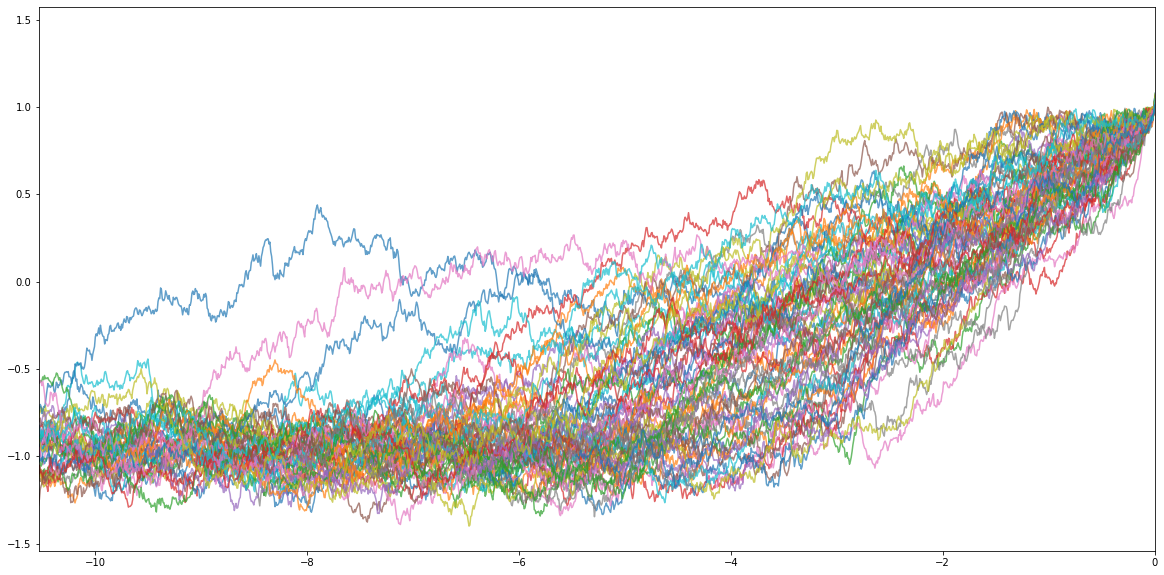

In [4]:
def main():
    np.random.seed(10) # Risultati riproducibili
    mu, sigma = 0, 1 # media e deviazione standard del processo di Wiener
    n, m, dt, eps = get_param() # prendo i parametri del problema
    
    # Inizializzo matrice delle posizioni e dei numeri casuali
    print('setting up')
    print('-ones matrix...')
    x = -1*np.ones((n,m)) # Tutti in -1 all'inizio
    print('rand matrix, wait some seconds...')
    dw = np.random.normal(mu, sigma, (n,m))
    
    # muovo i camminatori
    x = motion(x, dw)
    
    # Plotto i risultati e memorizzo i giusti percorsi e le giuste w
    right_paths = []
    right_w = []
    
    tj = n*dt
    t = np.arange(0,n*dt,dt)
    plt.figure(figsize=(20,10))
    for i in range(m):
        j = np.argmax(x[:,i]>=1) # Cerco la prima volta che è stato superato x=1
        if j > 0: # se fa 0 allora vuol dire che non ci è arrivato...
            plt.plot(t - t[j], x[:,i], alpha=0.7)
            right_paths.append(x[:,i])
            right_w.append(dw[:,i])
            if tj > t[j]:
                tj = t[j]
    plt.xlim(-3*tj,0)
    plt.show()
    return right_paths, right_w
p, w = main()

In [12]:
print(f'Numero di percorsi ottenuti: {len(p)}')
n, m, dt, eps = get_param()
print(f'rapporto eps/dt = {eps/dt}')
#%reset

71


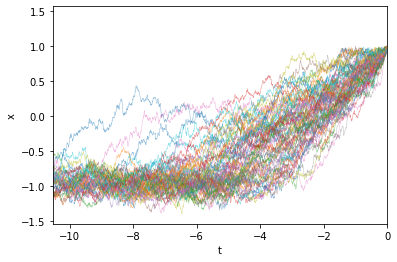

In [24]:
'''Per poter lavorare con i path ottenuti serve che:
    - Abbiano tutti lo zero dei tempi quando hanno toccato x = 1
    - 
'''

n, m, dt, eps = get_param()
t = np.arange(0,n*dt,dt)
jm = n
paths = []
# Cerco il camminatore che ci ha messo meno ad arrivare ad 1 (sarà questo a decretare la lunghezza degli x_n)
for path in p:
    j = np.argmax(path>=1)
    if jm > j:
        jm = j 

#time = np.arange(-t[jm],0,dt)
# Riformatto tutti gli array per avere la stessa lunghezza
times = []
for path in p:
    j = np.argmax(path>=1)
    if j > jm: # Escludo il più veloce (si potrebbe includere con una riga in più...)
        paths.append(path[:j]) # vado dal primo elemento fino al punto in cui x=1
        times.append(t[:j]-t[j]) # Creo un nuovo array di tempi sincronizzato con questo x_n

# Plotto i risultati in HD
num_plot = 70 # numero di plot da visualizzare
for path in p[:num_plot]:
    j = np.argmax(path>=1)
    plt.plot(t - t[j], path, alpha=0.5, linewidth=0.5)
plt.xlim(-3*t[jm],0)
plt.savefig("../../figures/lez_12_walker_t_path.png", dpi = 300) 
plt.xlabel('t')
plt.ylabel('x')
plt.show()

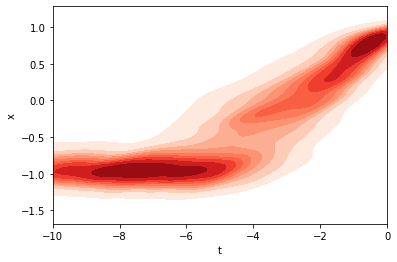

In [22]:
# Concateno tempi e percorsi per visualizzare la densità, avendo sincronizzato tutto non ci saranno problemi.
tot_path = np.concatenate([i for i in paths])
tot_time = np.concatenate([i for i in times])

# Seaborn nella sua incredibile lentezza vuole anche una pandas series anziche un numpy array...
path_series = pd.Series(tot_path)
time_series = pd.Series(tot_time)

plot = sns.kdeplot(x=time_series, y=path_series, cmap="Reds", shade=True)
plot.set(xlim=(-10,0))
plot.set(xlabel='t', ylabel='x')
plot.figure.savefig("../../figures/lez_12_walker_t.png", dpi = 300) 
plt.show()

In [34]:
nbins = 100
x = tot_time
y = tot_path
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [23]:
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='nearest', cmap=plt.cm.Reds)
plt.contour(xi, yi, zi.reshape(xi.shape), alpha = 0.1)
plt.xlim(-3*t[jm],0)
plt.show()

NameError: name 'xi' is not defined

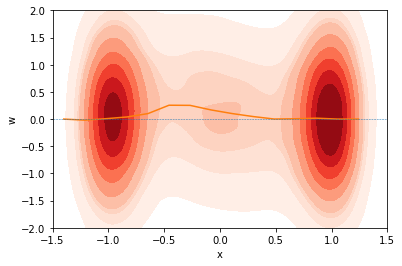

In [5]:
#for x, dw in zip(p,w):
#    plt.plot(x, dw, alpha=0.7)
    
tot_path1 = np.concatenate([i for i in p[:]])
tot_w = np.concatenate([i for i in w[:]])

path1_series = pd.Series(tot_path1)
w_series = pd.Series(tot_w)

# Adesso discretizziamo i percorsi ed valutiamo 
# su ciascuno di questi discretizzati la media del processo di wiener
bins = 15                                                  # numero di bins
step = (max(tot_path1)-min(tot_path1))/bins                # Il passo della discretizzazione
vec_step = np.arange(min(tot_path1), max(tot_path1), step) # percorso discretizzato

# Valuto la media dei w nell'intervallo del bin scelto a piacere
mean_w = np.zeros(bins)
for i in range(1, bins-2):
    mask = (tot_path1>=vec_step[i-1]) & (tot_path1 < vec_step[i]) # maschera per beccare i w appartenenti al bin
    mean_w[i] = np.mean(tot_w[mask]) # valuto la media su questi w

# Plotto i risultati
plot = sns.kdeplot(x=path1_series, y=w_series, cmap="Reds", shade=True)
plot.plot(vec_step, mean_w)
plot.axhline(0, ls='--', linewidth = 0.5)
plot.set(xlim=(-1.5,1.5))
plot.set(ylim=(-2,2))
plot.set(xlabel='x', ylabel='w')
plot.figure.savefig("../../figures/lez_12_dist.png", dpi = 300) 
plt.show()

In [37]:
#%reset